# **MODEL 3 - UNET**

# Architecture

Type info here

# Import Dependencies

In [1]:
# File Support
try: 
    import pydicom as dcm
except:
    # Use try except for Google Colab
    !pip install pydicom
from pydicom.data import get_testdata_files
import xml
import xml.etree.ElementTree as ET 

# Base
import numpy as np
import pandas as pd
import json
import random
import gc
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.path import Path
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import seaborn as sns
from PIL import Image

# SK-learn
import sklearn
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV

# Files
import os
from os.path import join, split
from glob import glob

# Torch
import torch
from torch import nn
from torch.nn import Sequential, Conv2d, MaxPool2d, ReLU, ConvTranspose2d
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import torchvision
from torchvision.transforms import CenterCrop
import torch.nn.functional as F
from torch.optim import AdamW
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.checkpoint import checkpoint
from torch.autograd import Variable

import tempfile
import torch.multiprocessing as mp
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed.fsdp import CPUOffload, wrap
import bitsandbytes as bnb

In [2]:
torch.__version__

'2.2.2+cu121'

In [3]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"

In [4]:
torch.cuda.is_available()

True

# Config

In [5]:
len(os.listdir("Numpy Dataset\\all\images"))

7547

In [6]:
class CFG:
    random_seed = 42
    gated = True
    path = "Coronary CT Data\Gated_release_final" if gated else "Coronary CT Data/deidentified_nongated"
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    train_new = True
    model_num = len(os.listdir("Models")) if train_new else len(os.listdir("Models"))-1

    batch_size = 8
    nEpochs = 100
    lr = 0.1


In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
torch.cuda.empty_cache()
gc.collect()

25

In [9]:
torch.cuda.memory_usage()

47

In [10]:
def setup(rank, world_size):
    os.environ['MASTER_ADDR'] = 'localhost'
    os.environ['MASTER_PORT'] = '12355'

    # initialize the process group
    dist.init_process_group("gloo", rank=rank, world_size=world_size)

def cleanup():
    dist.destroy_process_group()

## Reproducibility

In [11]:
def set_seed(seed=CFG.random_seed):
    print(f"Seed: {seed}")
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed()

Seed: 42


# Load Data

In [12]:
def parseXML(xmlfile): 
    # create element tree object 
    tree = ET.parse(xmlfile) 

    all_images = []

    images = tree.find("dict").find("array")
    images = images.findall("dict")

    # Images
    for image in images:
        image_data = {}
        arr = [i.text for i in image if i.tag not in ["array", "dict"]]
        
        for i in range(len(arr)//2):
            image_data[arr[2*i]] = arr[2*i+1]

        image_data['ROIs'] = []

        # ROI
        all_roi = image.find("array").findall('dict')
        for roi in all_roi:
            roi_data = {}
            arr = [i.text for i in roi if i.tag not in ["array", "dict"]]
        
            for i in range(len(arr)//2):
                roi_data[arr[2*i]] = arr[2*i+1]

            all_points = roi.findall('array')
            roi_data['point_mm'] = [i.text for i in all_points[0].findall("string")]
            roi_data['point_px'] = [i.text for i in all_points[1].findall("string")]
            
            image_data['ROIs'].append(roi_data)
        all_images.append(image_data)

    return all_images

In [13]:
def create_segments(image_array, points):
    polygon = Polygon(points, closed=True, edgecolor='r', facecolor='r')
    polygon_indices = np.array(points)
    polygon_indices[:, 0] = np.clip(polygon_indices[:, 0], 0, 511)
    polygon_indices[:, 1] = np.clip(polygon_indices[:, 1], 0, 511)
    image_array[polygon_indices[:, 1], polygon_indices[:, 0]] = 1
    polygon_path = Path(polygon_indices)
    x, y = np.meshgrid(np.arange(512), np.arange(512))
    points = np.column_stack((x.flatten(), y.flatten()))
    mask = polygon_path.contains_points(points).reshape(512, 512)
    image_array[mask] = 1

    return image_array

In [14]:
class CTDataset(Dataset):
    def __init__(self, dir):
        super().__init__()
        self.dir = dir
        self.images_path = join(dir, "images")
        self.labels_path = join(dir, "labels")
        self.images = os.listdir(self.images_path)
        self.labels = os.listdir(self.labels_path)

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx): # Return tuple (x, y)
        try:
            img = np.load(join(self.images_path, self.images[idx]), allow_pickle=True)
            img = img.reshape(1, 512, 512) # Hard coded since all images are 512, 512

            label = np.load(join(self.labels_path, self.labels[idx]), allow_pickle=True)
            label = label.reshape(1, 512, 512)
        except:
            img, label = np.zeros((1,512,512), np.float32),np.zeros((1,512,512), np.float32)
        return  img,label

In [15]:
train = CTDataset("Numpy Dataset\\train")
valid = CTDataset("Numpy Dataset\\valid")
test = CTDataset("Numpy Dataset\\test")

In [16]:
trainDL = DataLoader(train, batch_size=CFG.batch_size,shuffle=True, pin_memory=True)
validDL = DataLoader(valid, batch_size=CFG.batch_size)
testDL = DataLoader(test, batch_size=1)

In [17]:
print(f"Train: {len(train)}")
print(f"Valid: {len(valid)}")
print(f"Test: {len(test)}")

Train: 5331
Valid: 1598
Test: 616


# Model

In [18]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()

        self.conv1 = Conv2d(in_ch, out_ch, 3, padding=1)
        self.relu  = ReLU()
        self.conv2 = Conv2d(out_ch, out_ch, 3, padding=1)
        self.conv3 = Conv2d(out_ch, out_ch, 1, padding=0)

        # init random weights
        nn.init.xavier_normal_(self.conv1.weight)
        nn.init.zeros_(self.conv1.bias)

        nn.init.xavier_normal_(self.conv2.weight)
        nn.init.zeros_(self.conv2.bias)

        nn.init.xavier_normal_(self.conv3.weight)
        nn.init.zeros_(self.conv3.bias)
    
    def forward(self, x):
        return self.relu(self.conv3(self.relu(self.conv2(self.relu(self.conv1(x))))))

In [19]:
class AutoEncoder(nn.Module):
    def __init__(self, channels = (1,32,64,128,256,512,1024)):
        super().__init__()
        self.channels = channels
        self.pool = MaxPool2d((2,2))

        self.encoder = nn.ModuleList([
            Block(channels[i], channels[i+1]) for i in range(len(channels)-1) # 1, 32, ..., 1024
        ])

    def forward(self, x):
        skip_out = []
        for block in self.encoder: # Goes through all blocks, passes through block and saves skip output
            x = block(x)
            skip_out.append(x)
            x = self.pool(x) # Reduces dim
        return skip_out

In [20]:
class AutoDecoder(nn.Module):
    def __init__(self, channels = (1,32,64,128,256,512,1024)):
        super().__init__()
        self.channels = channels[:0:-1] # Reverse of Encoder (Excluding First Unneeded in Output)
        self.pool = MaxPool2d((2,2))
        self.upconv = nn.ModuleList([
            ConvTranspose2d(self.channels[i], self.channels[i+1], 2, 2) for i in range(len(self.channels)-1)
        ])

        self.decoder = nn.ModuleList([
            Block(self.channels[i], self.channels[i+1]) for i in range(len(self.channels)-1)
        ])

    def center_crop(self, x, enc_out): # Crop encoder output
        _, _, h, w = x.shape
        enc_out = CenterCrop([h,w])(enc_out)
        return enc_out
    
    def forward(self, x, enc_out:list):
        for i in range(len(self.channels)-1):
            x = self.upconv[i](x)
            enc_ftrs = self.center_crop(x, enc_out[i]) # Crop Skip
            x = torch.cat([x, enc_ftrs], dim=1) # Concatenate Decoder and Skip
            x = self.decoder[i](x)

            # Min Max Scaling [0,1]
            x = (x-x.min())/(x.max()-x.min())
        return x


In [21]:
class UNET(nn.Module):
    def __init__(self, channels = (1,32,64,128,256,512, 1024, 2048)):
        super().__init__()

        # Encoder Path
        self.enc_path = AutoEncoder(channels)

        # Decoder Path
        self.dec_path = AutoDecoder(channels)

        self.out1 = Conv2d(channels[1], 1, 1)
        self.out2 = Conv2d(in_channels=1,out_channels=1, kernel_size=3,stride=1,padding=1)

        # init random weights
        nn.init.xavier_normal_(self.out1.weight)
        nn.init.zeros_(self.out1.bias)

        nn.init.xavier_normal_(self.out2.weight)
        nn.init.zeros_(self.out2.bias)

        self.out = Sequential(self.out1,
                              self.out2)

    
    def forward(self, x):
        skips = self.enc_path(x)
        x = self.dec_path(skips[::-1][0], skips[::-1][1:]) 
        # Reverse of enc_out = upward path of decoder 
        #  [0] -> 1024 output
        # [1:] -> All other skip outputs
        x = self.out(x)
        x = F.sigmoid(x)

        return x

In [22]:
if not CFG.train_new:
    try:
        model = torch.load(f"Models/{CFG.model_name}/{CFG.model_name}.pt")
    except FileNotFoundError:
        print("Model not found in models folder")

# Train

## Dice Loss

Sørensen–Dice coefficient:
[Wikipedia](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient)
</br>
$${\displaystyle DSC={\frac {2|X\cap Y|}{|X|+|Y|}}}

In [23]:
class diceCoef(nn.Module):
    def init(self):
        super(diceCoef, self).init()

    def forward(self, inputs, targets, smooth=1):        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [24]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

In [25]:
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        #comment out if your model contains a sigmoid or equivalent activation layer        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return 1 - IoU

In [26]:
class TverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True, ALPHA = 0.5, BETA = 0.5):
        super(TverskyLoss, self).__init__()
        self.alpha = ALPHA
        self.beta = BETA

    def forward(self, inputs, targets, smooth=1):
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()    
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()
       
        Tversky = (TP + smooth) / (TP + self.alpha*FP + self.beta*FN + smooth)  
        
        return 1 - Tversky

In [27]:
criterion_dice_bce = DiceBCELoss()

In [28]:
criterion_dice = diceCoef()

In [29]:
criterion_iou = IoULoss()

In [30]:
criterion_bce = torch.nn.BCEWithLogitsLoss()

In [31]:
criterion_tversk = TverskyLoss()

## Training Loop

In [32]:
trainDL = DataLoader(train, batch_size=16, shuffle=True)
validDL = DataLoader(valid, batch_size=16, shuffle=False)

In [33]:
def train_epoch(model,  criterion, optim, scheduler):      
    train_loss = 0
    bce_loss = 0
    iou_loss = 0
    dice_loss = 0
    for x,y in tqdm(trainDL):
        x, y = x.to(CFG.device), y.to(CFG.device)
        optim.zero_grad()
        with torch.cuda.amp.autocast(dtype=torch.float16):
            pred = checkpoint(model, x).detach()
            loss = criterion(pred, y)
            loss = Variable(loss, requires_grad=True)
            
        loss.backward()
        optim.step()
        train_loss += loss
        del x,y,pred,loss
    
    
    # eval
    with torch.no_grad():
        for x,y in validDL:
            x, y = x.to(CFG.device), y.to(CFG.device)
            pred = model(x).detach()
            loss_bce = criterion_bce(pred, y)
            loss_dice = criterion_dice(pred,y)
            loss_iou = criterion_iou(pred, y)
            bce_loss += loss_bce
            iou_loss += loss_iou
            dice_loss += loss_dice
    
    scheduler.step(bce_loss)
        
    avg_train_loss = train_loss/len(trainDL)
    avg_bce_loss = bce_loss/len(validDL)
    avg_iou_loss = iou_loss/len(validDL)
    avg_dice_loss = dice_loss/len(validDL)

    
    print(f"Train Loss: {avg_train_loss}")
    print(f"Validation BCE Loss: {avg_bce_loss}")
    print(f"Validation Dice Loss: {avg_dice_loss}")
    print(f"Validation IOU Loss: {avg_iou_loss}")
    return avg_train_loss, avg_bce_loss

In [34]:
def run_model(criterion, model = None, init_lr = 0.1, name = "model", nEpochs = CFG.nEpochs):
    if not model:
        model = UNET().to(CFG.device)
    model.train()

    optim = AdamW(model.parameters(), lr=init_lr)
    scheduler = lr_scheduler.ReduceLROnPlateau(optim, factor=0.5, min_lr=0.0001, verbose=True)

    train_hist = []
    val_hist = []

    for e in range(nEpochs):
        print(f"\n\n[INFO] Epoch {e+1}/{nEpochs}")
        print(scheduler.optimizer.param_groups[0]['lr'])
        train_loss, val_loss = train_epoch(model, criterion, optim, scheduler)
        train_hist.append(float(train_loss.detach().cpu()))
        val_hist.append(float(val_loss.detach().cpu()))

    if not os.path.exists(f"Models/{name}"):
        os.mkdir(f"Models/{name}")
    torch.save(model.state_dict(), f"Models/{name}/model.pt")

    history = pd.DataFrame({"train":train_hist, 
                         'validation':val_hist}, index = range(1,len(train_hist)+1))
    
    history.to_csv(f"Models/{name}/logs.csv")

In [35]:
for i in range(100):
    a = random.randint(70,100)/100
    b = random.randint(1,30)/100

    criterion = TverskyLoss(ALPHA = a, BETA = b)
    
    run_model(criterion, name=f"Tversky4-{i}", nEpochs=2)

    with open(f"Models/Tversky4-{i}/info.txt", "w") as file:
        file.write(f"Alpha: {a} \nBETA: {b}")
        file.close()



[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:22<00:00,  4.04it/s]


Train Loss: 0.9998047947883606
Validation BCE Loss: 0.969146192073822
Validation Dice Loss: 0.9999673366546631
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:17<00:00,  4.33it/s]


Train Loss: 0.9998058080673218
Validation BCE Loss: 0.969146192073822
Validation Dice Loss: 0.9999673366546631
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.44it/s]


Train Loss: 0.9997476935386658
Validation BCE Loss: 0.9846397042274475
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997482299804688
Validation BCE Loss: 0.9846397042274475
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.44it/s]


Train Loss: 0.9997725486755371
Validation BCE Loss: 0.9789972305297852
Validation Dice Loss: 0.9999670386314392
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997727274894714
Validation BCE Loss: 0.9789972305297852
Validation Dice Loss: 0.9999670386314392
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.44it/s]


Train Loss: 0.9997687935829163
Validation BCE Loss: 0.9904482960700989
Validation Dice Loss: 0.9999668002128601
Validation IOU Loss: 0.9999831914901733


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997684359550476
Validation BCE Loss: 0.9904482960700989
Validation Dice Loss: 0.9999668002128601
Validation IOU Loss: 0.9999831914901733


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.44it/s]


Train Loss: 0.9998103380203247
Validation BCE Loss: 0.9797186255455017
Validation Dice Loss: 0.9999670386314392
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.44it/s]


Train Loss: 0.999809980392456
Validation BCE Loss: 0.9797186255455017
Validation Dice Loss: 0.9999670386314392
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.44it/s]


Train Loss: 0.9998070597648621
Validation BCE Loss: 0.9684816002845764
Validation Dice Loss: 0.9999673366546631
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.44it/s]


Train Loss: 0.9998068809509277
Validation BCE Loss: 0.9684816002845764
Validation Dice Loss: 0.9999673366546631
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9998206496238708
Validation BCE Loss: 0.9673427939414978
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9998200535774231
Validation BCE Loss: 0.9673427939414978
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997544288635254
Validation BCE Loss: 0.9815614819526672
Validation Dice Loss: 0.9999668002128601
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997547268867493
Validation BCE Loss: 0.9815614819526672
Validation Dice Loss: 0.9999668002128601
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.44it/s]


Train Loss: 0.9997869729995728
Validation BCE Loss: 0.9849852323532104
Validation Dice Loss: 0.9999668002128601
Validation IOU Loss: 0.9999832510948181


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.44it/s]


Train Loss: 0.9997864961624146
Validation BCE Loss: 0.9849852323532104
Validation Dice Loss: 0.9999668002128601
Validation IOU Loss: 0.9999832510948181


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997475743293762
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997473359107971
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.44it/s]


Train Loss: 0.999769389629364
Validation BCE Loss: 0.9349266886711121
Validation Dice Loss: 0.9999673366546631
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.44it/s]


Train Loss: 0.9997692108154297
Validation BCE Loss: 0.9349266886711121
Validation Dice Loss: 0.9999673366546631
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.44it/s]


Train Loss: 0.9997949004173279
Validation BCE Loss: 0.960497260093689
Validation Dice Loss: 0.9999673366546631
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997966289520264
Validation BCE Loss: 0.960497260093689
Validation Dice Loss: 0.9999673366546631
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.999748706817627
Validation BCE Loss: 0.972174346446991
Validation Dice Loss: 0.9999670386314392
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997476935386658
Validation BCE Loss: 0.972174346446991
Validation Dice Loss: 0.9999670386314392
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.44it/s]


Train Loss: 0.9997677803039551
Validation BCE Loss: 0.9842956066131592
Validation Dice Loss: 0.9999669194221497
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997668862342834
Validation BCE Loss: 0.9842956066131592
Validation Dice Loss: 0.9999669194221497
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9998007416725159
Validation BCE Loss: 1.0023192167282104
Validation Dice Loss: 0.9999666213989258
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9998012781143188
Validation BCE Loss: 1.0023192167282104
Validation Dice Loss: 0.9999666213989258
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9998012185096741
Validation BCE Loss: 0.9489579796791077
Validation Dice Loss: 0.9999679923057556
Validation IOU Loss: 0.9999837875366211


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9998024106025696
Validation BCE Loss: 0.9489579796791077
Validation Dice Loss: 0.9999679923057556
Validation IOU Loss: 0.9999837875366211


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997714161872864
Validation BCE Loss: 0.9869418144226074
Validation Dice Loss: 0.9999672770500183
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.44it/s]


Train Loss: 0.9997705817222595
Validation BCE Loss: 0.9869418144226074
Validation Dice Loss: 0.9999672770500183
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9998013973236084
Validation BCE Loss: 0.8736476898193359
Validation Dice Loss: 0.999967098236084
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997998476028442
Validation BCE Loss: 0.8736476898193359
Validation Dice Loss: 0.999967098236084
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9998147487640381
Validation BCE Loss: 0.975904643535614
Validation Dice Loss: 0.9999670386314392
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9998136162757874
Validation BCE Loss: 0.975904643535614
Validation Dice Loss: 0.9999670386314392
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.44it/s]


Train Loss: 0.9997480511665344
Validation BCE Loss: 0.9823481440544128
Validation Dice Loss: 0.9999670386314392
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997475743293762
Validation BCE Loss: 0.9823481440544128
Validation Dice Loss: 0.9999670386314392
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.44it/s]


Train Loss: 0.9998177289962769
Validation BCE Loss: 0.9315944314002991
Validation Dice Loss: 0.9999678730964661
Validation IOU Loss: 0.9999836683273315


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9998173117637634
Validation BCE Loss: 0.9315944314002991
Validation Dice Loss: 0.9999678730964661
Validation IOU Loss: 0.9999836683273315


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9998085498809814
Validation BCE Loss: 0.9688513875007629
Validation Dice Loss: 0.9999672770500183
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9998089671134949
Validation BCE Loss: 0.9688513875007629
Validation Dice Loss: 0.9999672770500183
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997739791870117
Validation BCE Loss: 1.082889437675476
Validation Dice Loss: 0.999966025352478
Validation IOU Loss: 0.9999828934669495


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997730851173401
Validation BCE Loss: 1.082889437675476
Validation Dice Loss: 0.999966025352478
Validation IOU Loss: 0.9999828934669495


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997614622116089
Validation BCE Loss: 0.9827033281326294
Validation Dice Loss: 0.9999669194221497
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997598528862
Validation BCE Loss: 0.9827033281326294
Validation Dice Loss: 0.9999669194221497
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.999819278717041
Validation BCE Loss: 1.0489479303359985
Validation Dice Loss: 0.9999662637710571
Validation IOU Loss: 0.9999828934669495


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9998195171356201
Validation BCE Loss: 1.0489479303359985
Validation Dice Loss: 0.9999662637710571
Validation IOU Loss: 0.9999828934669495


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.44it/s]


Train Loss: 0.9997806549072266
Validation BCE Loss: 0.9741131663322449
Validation Dice Loss: 0.9999673366546631
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997803568840027
Validation BCE Loss: 0.9741131663322449
Validation Dice Loss: 0.9999673366546631
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997580647468567
Validation BCE Loss: 0.966816782951355
Validation Dice Loss: 0.9999675750732422
Validation IOU Loss: 0.999983549118042


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997581839561462
Validation BCE Loss: 0.966816782951355
Validation Dice Loss: 0.9999675750732422
Validation IOU Loss: 0.999983549118042


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997557401657104
Validation BCE Loss: 0.9996606707572937
Validation Dice Loss: 0.9999666213989258
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997552633285522
Validation BCE Loss: 0.9996606707572937
Validation Dice Loss: 0.9999666213989258
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.44it/s]


Train Loss: 0.9998178482055664
Validation BCE Loss: 0.9797802567481995
Validation Dice Loss: 0.9999670386314392
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9998179078102112
Validation BCE Loss: 0.9797802567481995
Validation Dice Loss: 0.9999670386314392
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.44it/s]


Train Loss: 0.9998053312301636
Validation BCE Loss: 0.9510749578475952
Validation Dice Loss: 0.9999678730964661
Validation IOU Loss: 0.9999836683273315


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9998055100440979
Validation BCE Loss: 0.9510749578475952
Validation Dice Loss: 0.9999678730964661
Validation IOU Loss: 0.9999836683273315


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9998146295547485
Validation BCE Loss: 0.9682478308677673
Validation Dice Loss: 0.999967098236084
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9998146295547485
Validation BCE Loss: 0.9682478308677673
Validation Dice Loss: 0.999967098236084
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9998109936714172
Validation BCE Loss: 0.9675462245941162
Validation Dice Loss: 0.9999673366546631
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9998115301132202
Validation BCE Loss: 0.9675462245941162
Validation Dice Loss: 0.9999673366546631
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997952580451965
Validation BCE Loss: 0.9843405485153198
Validation Dice Loss: 0.9999668002128601
Validation IOU Loss: 0.9999832510948181


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997959136962891
Validation BCE Loss: 0.9843405485153198
Validation Dice Loss: 0.9999668002128601
Validation IOU Loss: 0.9999832510948181


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9998181462287903
Validation BCE Loss: 1.0045603513717651
Validation Dice Loss: 0.999966561794281
Validation IOU Loss: 0.999983012676239


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9998189210891724
Validation BCE Loss: 1.0045603513717651
Validation Dice Loss: 0.999966561794281
Validation IOU Loss: 0.999983012676239


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.44it/s]


Train Loss: 0.9997529983520508
Validation BCE Loss: 1.0044124126434326
Validation Dice Loss: 0.9999668002128601
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997539520263672
Validation BCE Loss: 1.0044124126434326
Validation Dice Loss: 0.9999668002128601
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997751116752625
Validation BCE Loss: 1.0019474029541016
Validation Dice Loss: 0.9999668598175049
Validation IOU Loss: 0.9999832510948181


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997752904891968
Validation BCE Loss: 1.0019474029541016
Validation Dice Loss: 0.9999668598175049
Validation IOU Loss: 0.9999832510948181


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9998059868812561
Validation BCE Loss: 0.9644016027450562
Validation Dice Loss: 0.9999673962593079
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.44it/s]


Train Loss: 0.9998053908348083
Validation BCE Loss: 0.9644016027450562
Validation Dice Loss: 0.9999673962593079
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.999818742275238
Validation BCE Loss: 0.9833603501319885
Validation Dice Loss: 0.9999668598175049
Validation IOU Loss: 0.9999832510948181


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9998171329498291
Validation BCE Loss: 0.9833603501319885
Validation Dice Loss: 0.9999668598175049
Validation IOU Loss: 0.9999832510948181


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997820258140564
Validation BCE Loss: 0.9725244641304016
Validation Dice Loss: 0.9999670386314392
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997810125350952
Validation BCE Loss: 0.9725244641304016
Validation Dice Loss: 0.9999670386314392
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997667670249939
Validation BCE Loss: 1.0044950246810913
Validation Dice Loss: 0.9999668002128601
Validation IOU Loss: 0.9999832510948181


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997668862342834
Validation BCE Loss: 1.0044950246810913
Validation Dice Loss: 0.9999668002128601
Validation IOU Loss: 0.9999832510948181


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997537732124329
Validation BCE Loss: 0.9746573567390442
Validation Dice Loss: 0.9999668002128601
Validation IOU Loss: 0.9999832510948181


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997535943984985
Validation BCE Loss: 0.9746573567390442
Validation Dice Loss: 0.9999668002128601
Validation IOU Loss: 0.9999832510948181


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.44it/s]


Train Loss: 0.9998058080673218
Validation BCE Loss: 0.996150016784668
Validation Dice Loss: 0.9999669194221497
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9998053312301636
Validation BCE Loss: 0.996150016784668
Validation Dice Loss: 0.9999669194221497
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9998116493225098
Validation BCE Loss: 0.9719301462173462
Validation Dice Loss: 0.9999670386314392
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9998122453689575
Validation BCE Loss: 0.9719301462173462
Validation Dice Loss: 0.9999670386314392
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.44it/s]


Train Loss: 0.9997554421424866
Validation BCE Loss: 0.9751115441322327
Validation Dice Loss: 0.999967098236084
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997556209564209
Validation BCE Loss: 0.9751115441322327
Validation Dice Loss: 0.999967098236084
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.44it/s]


Train Loss: 0.9997707605361938
Validation BCE Loss: 0.9335417151451111
Validation Dice Loss: 0.9999668002128601
Validation IOU Loss: 0.9999831914901733


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.999770998954773
Validation BCE Loss: 0.9335417151451111
Validation Dice Loss: 0.9999668002128601
Validation IOU Loss: 0.9999831914901733


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997583627700806
Validation BCE Loss: 0.9767884016036987
Validation Dice Loss: 0.999967098236084
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997580051422119
Validation BCE Loss: 0.9767884016036987
Validation Dice Loss: 0.999967098236084
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997735023498535
Validation BCE Loss: 0.9522737860679626
Validation Dice Loss: 0.999967098236084
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997745156288147
Validation BCE Loss: 0.9522737860679626
Validation Dice Loss: 0.999967098236084
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.44it/s]


Train Loss: 0.9998072385787964
Validation BCE Loss: 1.0517977476119995
Validation Dice Loss: 0.9999677538871765
Validation IOU Loss: 0.9999837279319763


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9998067617416382
Validation BCE Loss: 1.0517977476119995
Validation Dice Loss: 0.9999677538871765
Validation IOU Loss: 0.9999837279319763


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997816681861877
Validation BCE Loss: 0.972351610660553
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997820258140564
Validation BCE Loss: 0.972351610660553
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.999782383441925
Validation BCE Loss: 0.9393137693405151
Validation Dice Loss: 0.9999668598175049
Validation IOU Loss: 0.9999832510948181


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997830390930176
Validation BCE Loss: 0.9393137693405151
Validation Dice Loss: 0.9999668598175049
Validation IOU Loss: 0.9999832510948181


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997633695602417
Validation BCE Loss: 1.0124772787094116
Validation Dice Loss: 0.9999663233757019
Validation IOU Loss: 0.999983012676239


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997621774673462
Validation BCE Loss: 1.0124772787094116
Validation Dice Loss: 0.9999663233757019
Validation IOU Loss: 0.999983012676239


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997763633728027
Validation BCE Loss: 0.917202889919281
Validation Dice Loss: 0.9999676942825317
Validation IOU Loss: 0.9999834895133972


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997774362564087
Validation BCE Loss: 0.917202889919281
Validation Dice Loss: 0.9999676942825317
Validation IOU Loss: 0.9999834895133972


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9998219609260559
Validation BCE Loss: 1.0021984577178955
Validation Dice Loss: 0.9999669194221497
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.999821126461029
Validation BCE Loss: 1.0021984577178955
Validation Dice Loss: 0.9999669194221497
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9998036623001099
Validation BCE Loss: 0.9758110642433167
Validation Dice Loss: 0.9999670386314392
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9998044371604919
Validation BCE Loss: 0.9758110642433167
Validation Dice Loss: 0.9999670386314392
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9998016953468323
Validation BCE Loss: 0.9726680517196655
Validation Dice Loss: 0.9999670386314392
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.999801516532898
Validation BCE Loss: 0.9726680517196655
Validation Dice Loss: 0.9999670386314392
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997641444206238
Validation BCE Loss: 0.9937011003494263
Validation Dice Loss: 0.9999668598175049
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997642040252686
Validation BCE Loss: 0.9937011003494263
Validation Dice Loss: 0.9999668598175049
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.44it/s]


Train Loss: 0.9998103380203247
Validation BCE Loss: 0.9775295853614807
Validation Dice Loss: 0.9999670386314392
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.999810516834259
Validation BCE Loss: 0.9775295853614807
Validation Dice Loss: 0.9999670386314392
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997687935829163
Validation BCE Loss: 0.9621228575706482
Validation Dice Loss: 0.9999677538871765
Validation IOU Loss: 0.9999837279319763


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997690320014954
Validation BCE Loss: 0.9621228575706482
Validation Dice Loss: 0.9999677538871765
Validation IOU Loss: 0.9999837279319763


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997852444648743
Validation BCE Loss: 0.9832786917686462
Validation Dice Loss: 0.9999672770500183
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997857809066772
Validation BCE Loss: 0.9832786917686462
Validation Dice Loss: 0.9999672770500183
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9998218417167664
Validation BCE Loss: 0.9749069809913635
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9998220205307007
Validation BCE Loss: 0.9749069809913635
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9998087882995605
Validation BCE Loss: 0.9765756130218506
Validation Dice Loss: 0.999967098236084
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9998089075088501
Validation BCE Loss: 0.9765756130218506
Validation Dice Loss: 0.999967098236084
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.44it/s]


Train Loss: 0.9997726082801819
Validation BCE Loss: 0.9746813178062439
Validation Dice Loss: 0.9999672770500183
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997719526290894
Validation BCE Loss: 0.9746813178062439
Validation Dice Loss: 0.9999672770500183
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997791051864624
Validation BCE Loss: 0.974288284778595
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997795820236206
Validation BCE Loss: 0.974288284778595
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9998090863227844
Validation BCE Loss: 1.0014126300811768
Validation Dice Loss: 0.9999663233757019
Validation IOU Loss: 0.999983012676239


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9998091459274292
Validation BCE Loss: 1.0014126300811768
Validation Dice Loss: 0.9999663233757019
Validation IOU Loss: 0.999983012676239


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997568726539612
Validation BCE Loss: 0.9778223037719727
Validation Dice Loss: 0.9999678730964661
Validation IOU Loss: 0.9999837279319763


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997563362121582
Validation BCE Loss: 0.9778223037719727
Validation Dice Loss: 0.9999678730964661
Validation IOU Loss: 0.9999837279319763


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9998156428337097
Validation BCE Loss: 0.9839692711830139
Validation Dice Loss: 0.9999668002128601
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9998149275779724
Validation BCE Loss: 0.9839692711830139
Validation Dice Loss: 0.9999668002128601
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.44it/s]


Train Loss: 0.9998131990432739
Validation BCE Loss: 0.9801070690155029
Validation Dice Loss: 0.9999669194221497
Validation IOU Loss: 0.9999832510948181


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9998139142990112
Validation BCE Loss: 0.9801070690155029
Validation Dice Loss: 0.9999669194221497
Validation IOU Loss: 0.9999832510948181


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997773766517639
Validation BCE Loss: 1.0231503248214722
Validation Dice Loss: 0.9999657273292542
Validation IOU Loss: 0.9999827146530151


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997782111167908
Validation BCE Loss: 1.0231503248214722
Validation Dice Loss: 0.9999657273292542
Validation IOU Loss: 0.9999827146530151


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997509717941284
Validation BCE Loss: 0.9845266342163086
Validation Dice Loss: 0.999966561794281
Validation IOU Loss: 0.999983012676239


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997511506080627
Validation BCE Loss: 0.9845266342163086
Validation Dice Loss: 0.999966561794281
Validation IOU Loss: 0.999983012676239


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.44it/s]


Train Loss: 0.9998226761817932
Validation BCE Loss: 0.9759114384651184
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9998221397399902
Validation BCE Loss: 0.9759114384651184
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9998197555541992
Validation BCE Loss: 0.9722819924354553
Validation Dice Loss: 0.9999669194221497
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9998197555541992
Validation BCE Loss: 0.9722819924354553
Validation Dice Loss: 0.9999669194221497
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.999782145023346
Validation BCE Loss: 0.9053034782409668
Validation Dice Loss: 0.9999673366546631
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997811317443848
Validation BCE Loss: 0.9053034782409668
Validation Dice Loss: 0.9999673366546631
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9998034834861755
Validation BCE Loss: 0.9734607338905334
Validation Dice Loss: 0.9999673366546631
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.999804675579071
Validation BCE Loss: 0.9734607338905334
Validation Dice Loss: 0.9999673366546631
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997868537902832
Validation BCE Loss: 0.9063022136688232
Validation Dice Loss: 0.9999675750732422
Validation IOU Loss: 0.9999836683273315


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997876882553101
Validation BCE Loss: 0.9063022136688232
Validation Dice Loss: 0.9999675750732422
Validation IOU Loss: 0.9999836683273315


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9998217821121216
Validation BCE Loss: 0.9685090184211731
Validation Dice Loss: 0.9999673366546631
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9998229742050171
Validation BCE Loss: 0.9685090184211731
Validation Dice Loss: 0.9999673366546631
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997899532318115
Validation BCE Loss: 0.9746476411819458
Validation Dice Loss: 0.9999669194221497
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997884035110474
Validation BCE Loss: 0.9746476411819458
Validation Dice Loss: 0.9999669194221497
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.44it/s]


Train Loss: 0.999774158000946
Validation BCE Loss: 0.9733321070671082
Validation Dice Loss: 0.9999669194221497
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997708797454834
Validation BCE Loss: 0.9733321070671082
Validation Dice Loss: 0.9999669194221497
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997715950012207
Validation BCE Loss: 0.9743156433105469
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997705817222595
Validation BCE Loss: 0.9743156433105469
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9998003840446472
Validation BCE Loss: 0.9436983466148376
Validation Dice Loss: 0.9999675750732422
Validation IOU Loss: 0.9999836683273315


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9998003244400024
Validation BCE Loss: 0.9436983466148376
Validation Dice Loss: 0.9999675750732422
Validation IOU Loss: 0.9999836683273315


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.44it/s]


Train Loss: 0.9997676610946655
Validation BCE Loss: 1.0115115642547607
Validation Dice Loss: 0.9999662041664124
Validation IOU Loss: 0.9999829530715942


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997676610946655
Validation BCE Loss: 1.0115115642547607
Validation Dice Loss: 0.9999662041664124
Validation IOU Loss: 0.9999829530715942


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997954368591309
Validation BCE Loss: 1.0112969875335693
Validation Dice Loss: 0.9999663233757019
Validation IOU Loss: 0.999983012676239


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997960925102234
Validation BCE Loss: 1.0112969875335693
Validation Dice Loss: 0.9999663233757019
Validation IOU Loss: 0.999983012676239


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9998204112052917
Validation BCE Loss: 0.9765647649765015
Validation Dice Loss: 0.9999673366546631
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9998206496238708
Validation BCE Loss: 0.9765647649765015
Validation Dice Loss: 0.9999673366546631
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997881650924683
Validation BCE Loss: 0.9499725103378296
Validation Dice Loss: 0.9999675750732422
Validation IOU Loss: 0.999983549118042


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997891783714294
Validation BCE Loss: 0.9499725103378296
Validation Dice Loss: 0.9999675750732422
Validation IOU Loss: 0.999983549118042


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997722506523132
Validation BCE Loss: 0.9767541885375977
Validation Dice Loss: 0.9999673366546631
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997713565826416
Validation BCE Loss: 0.9767541885375977
Validation Dice Loss: 0.9999673366546631
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997917413711548
Validation BCE Loss: 1.0134472846984863
Validation Dice Loss: 0.9999663829803467
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997912645339966
Validation BCE Loss: 1.0134472846984863
Validation Dice Loss: 0.9999663829803467
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997501373291016
Validation BCE Loss: 1.0320193767547607
Validation Dice Loss: 0.9999663233757019
Validation IOU Loss: 0.999983012676239


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997504353523254
Validation BCE Loss: 1.0320193767547607
Validation Dice Loss: 0.9999663233757019
Validation IOU Loss: 0.999983012676239


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997519850730896
Validation BCE Loss: 0.97462397813797
Validation Dice Loss: 0.9999670386314392
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997521638870239
Validation BCE Loss: 0.97462397813797
Validation Dice Loss: 0.9999670386314392
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.999758243560791
Validation BCE Loss: 0.9821867942810059
Validation Dice Loss: 0.999967098236084
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997581839561462
Validation BCE Loss: 0.9821867942810059
Validation Dice Loss: 0.999967098236084
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.99980229139328
Validation BCE Loss: 0.9685698747634888
Validation Dice Loss: 0.9999668598175049
Validation IOU Loss: 0.9999831914901733


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9998024106025696
Validation BCE Loss: 0.9685698747634888
Validation Dice Loss: 0.9999668598175049
Validation IOU Loss: 0.9999831914901733


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.44it/s]


Train Loss: 0.9998151063919067
Validation BCE Loss: 0.9612234830856323
Validation Dice Loss: 0.9999673366546631
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9998154044151306
Validation BCE Loss: 0.9612234830856323
Validation Dice Loss: 0.9999673366546631
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997892379760742
Validation BCE Loss: 0.9656918048858643
Validation Dice Loss: 0.9999673962593079
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.999788761138916
Validation BCE Loss: 0.9656918048858643
Validation Dice Loss: 0.9999673962593079
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997557401657104
Validation BCE Loss: 0.9742724299430847
Validation Dice Loss: 0.999967098236084
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997554421424866
Validation BCE Loss: 0.9742724299430847
Validation Dice Loss: 0.999967098236084
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997945427894592
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997950196266174
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997987747192383
Validation BCE Loss: 0.9635922312736511
Validation Dice Loss: 0.9999687671661377
Validation IOU Loss: 0.9999842047691345


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.999799907207489
Validation BCE Loss: 0.9635922312736511
Validation Dice Loss: 0.9999687671661377
Validation IOU Loss: 0.9999842047691345


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997702240943909
Validation BCE Loss: 1.0009945631027222
Validation Dice Loss: 0.9999666213989258
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997705817222595
Validation BCE Loss: 1.0009945631027222
Validation Dice Loss: 0.9999666213989258
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9998175501823425
Validation BCE Loss: 0.9779126048088074
Validation Dice Loss: 0.9999670386314392
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9998173713684082
Validation BCE Loss: 0.9779126048088074
Validation Dice Loss: 0.9999670386314392
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9998059868812561
Validation BCE Loss: 0.972756564617157
Validation Dice Loss: 0.999967098236084
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9998067617416382
Validation BCE Loss: 0.972756564617157
Validation Dice Loss: 0.999967098236084
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997560977935791
Validation BCE Loss: 0.9831905961036682
Validation Dice Loss: 0.999966561794281
Validation IOU Loss: 0.9999831914901733


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9997560977935791
Validation BCE Loss: 0.9831905961036682
Validation Dice Loss: 0.999966561794281
Validation IOU Loss: 0.9999831914901733


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.44it/s]


Train Loss: 0.99982088804245
Validation BCE Loss: 0.9914823770523071
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9998202919960022
Validation BCE Loss: 0.9914823770523071
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 1/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9998112916946411
Validation BCE Loss: 1.0031590461730957
Validation Dice Loss: 0.9999668598175049
Validation IOU Loss: 0.9999832510948181


[INFO] Epoch 2/2
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9998104572296143
Validation BCE Loss: 1.0031590461730957
Validation Dice Loss: 0.9999668598175049
Validation IOU Loss: 0.9999832510948181


In [36]:
losses = {}
for i in glob("Models/**"):
    if os.path.exists(f"{i}\logs.csv"):
        try:
            file_loss = min(pd.read_csv(f"{i}\logs.csv")["validation"])
            losses[split(i)[-1]] = file_loss
        except:
            continue

In [37]:
losses_train = {}
for i in glob("Models/**"):
    if os.path.exists(f"{i}\logs.csv"):
        try:
            file_loss = min(pd.read_csv(f"{i}\logs.csv")["train"])
            losses_train[split(i)[-1]] = file_loss
        except:
            continue

In [38]:
retrain = sorted([losses[i] for i in losses.keys() if "Tversky4-" in i])[0:1]
retrain

[0.8721439838409424]

In [39]:
retrain_train = sorted([losses_train[i] for i in losses_train.keys() if "Tversky4-" in i])[0:1]
retrain_train

[0.9997473359107972]

In [40]:
retrain_models = []

for i in losses:
    if losses[i] in retrain or losses[i] in retrain_train:
        if "Tversky4" in i:
            print(i)
            best = f"Models/{i}/model.pt"
            retrain_models.append(best)
for i in losses_train:
    if losses_train[i] in retrain or losses_train[i] in retrain_train:
        if "Tversky4" in i:
            print(i)
            best = f"Models/{i}/model.pt"
            retrain_models.append(best)

Tversky4-92
Tversky4-9


In [41]:
all_models = {}
TRAIN = True
if TRAIN:
    for i in retrain_models:
        try:
            model = UNET().to(CFG.device)
            model.load_state_dict(torch.load(i))
            
            info = split(i)[0]+ "/info.txt"
            with open(info, "r") as file:
                for line in file:
                    if "Alpha" in line:
                        a = float(line.replace("Alpha: ", ""))
                    if "BETA" in line:
                        a = float(line.replace("BETA: ", ""))
            
            criterion = TverskyLoss(ALPHA = a, BETA = b)
            run_model(model = model, criterion=criterion, name=f"Fine Tuned {i.split('/')[1]}", nEpochs=100)
            all_models[i] = model.state_dict()
        except:
            pass



[INFO] Epoch 1/100
0.1


100%|██████████| 334/334 [01:14<00:00,  4.45it/s]


Train Loss: 0.9991588592529297
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 2/100
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9991576075553894
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 3/100
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9991510510444641
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 4/100
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9991596341133118
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 5/100
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9991550445556641
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 6/100
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9991586208343506
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 7/100
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9991587996482849
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 8/100
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9991571307182312
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 9/100
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9991594552993774
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 10/100
0.1


100%|██████████| 334/334 [01:14<00:00,  4.45it/s]


Train Loss: 0.9991602301597595
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 11/100
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.999160647392273
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 12/100
0.1


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9991589784622192
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 13/100
0.05


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9991596937179565
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 14/100
0.05


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9991593360900879
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 15/100
0.05


100%|██████████| 334/334 [01:14<00:00,  4.45it/s]


Train Loss: 0.9991579651832581
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 16/100
0.05


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.999158501625061
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 17/100
0.05


100%|██████████| 334/334 [01:14<00:00,  4.45it/s]


Train Loss: 0.9991576075553894
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 18/100
0.05


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9991582632064819
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 19/100
0.05


100%|██████████| 334/334 [01:14<00:00,  4.45it/s]


Train Loss: 0.999160647392273
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 20/100
0.05


100%|██████████| 334/334 [01:14<00:00,  4.45it/s]


Train Loss: 0.9991598725318909
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 21/100
0.05


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9991602301597595
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 22/100
0.05


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9991492033004761
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 23/100
0.05


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9991599917411804
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 24/100
0.025


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9991596937179565
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 25/100
0.025


100%|██████████| 334/334 [01:14<00:00,  4.45it/s]


Train Loss: 0.9991569519042969
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 26/100
0.025


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.999160647392273
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 27/100
0.025


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9991591572761536
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 28/100
0.025


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9991608262062073
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 29/100
0.025


100%|██████████| 334/334 [01:14<00:00,  4.45it/s]


Train Loss: 0.9991601705551147
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 30/100
0.025


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.99915611743927
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 31/100
0.025


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9991568922996521
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 32/100
0.025


100%|██████████| 334/334 [01:14<00:00,  4.45it/s]


Train Loss: 0.99915611743927
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 33/100
0.025


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9991587996482849
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 34/100
0.025


100%|██████████| 334/334 [01:14<00:00,  4.45it/s]


Train Loss: 0.9991604089736938
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 35/100
0.0125


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9991587996482849
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 36/100
0.0125


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9991531372070312
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 37/100
0.0125


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9991601705551147
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 38/100
0.0125


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9991601705551147
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 39/100
0.0125


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9991577863693237
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 40/100
0.0125


100%|██████████| 334/334 [01:14<00:00,  4.45it/s]


Train Loss: 0.9991536736488342
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 41/100
0.0125


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9991603493690491
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 42/100
0.0125


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9991565942764282
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 43/100
0.0125


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9991603493690491
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 44/100
0.0125


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9991607069969177
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 45/100
0.0125


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9991591572761536
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 46/100
0.00625


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9991565942764282
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 47/100
0.00625


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9991551637649536
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 48/100
0.00625


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9991600513458252
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 49/100
0.00625


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9991599917411804
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 50/100
0.00625


100%|██████████| 334/334 [01:14<00:00,  4.45it/s]


Train Loss: 0.9991592764854431
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 51/100
0.00625


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9991594552993774
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 52/100
0.00625


100%|██████████| 334/334 [01:14<00:00,  4.45it/s]


Train Loss: 0.9991595149040222
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 53/100
0.00625


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9991602301597595
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 54/100
0.00625


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9991580843925476
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 55/100
0.00625


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9991577863693237
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 56/100
0.00625


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.999160885810852
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 57/100
0.003125


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9991589784622192
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 58/100
0.003125


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9991586208343506
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 59/100
0.003125


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.999159038066864
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 60/100
0.003125


100%|██████████| 334/334 [01:14<00:00,  4.45it/s]


Train Loss: 0.9991601705551147
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 61/100
0.003125


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9991602301597595
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 62/100
0.003125


100%|██████████| 334/334 [01:14<00:00,  4.45it/s]


Train Loss: 0.9991598725318909
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 63/100
0.003125


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9991599917411804
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 64/100
0.003125


100%|██████████| 334/334 [01:14<00:00,  4.45it/s]


Train Loss: 0.9991601705551147
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 65/100
0.003125


100%|██████████| 334/334 [01:14<00:00,  4.45it/s]


Train Loss: 0.9991573095321655
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 66/100
0.003125


100%|██████████| 334/334 [01:14<00:00,  4.45it/s]


Train Loss: 0.9991593360900879
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 67/100
0.003125


100%|██████████| 334/334 [01:14<00:00,  4.45it/s]


Train Loss: 0.9991600513458252
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 68/100
0.0015625


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9991579055786133
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 69/100
0.0015625


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9991557598114014
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 70/100
0.0015625


100%|██████████| 334/334 [01:14<00:00,  4.45it/s]


Train Loss: 0.9991560578346252
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 71/100
0.0015625


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9991591572761536
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 72/100
0.0015625


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.999158501625061
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 73/100
0.0015625


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9991596341133118
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 74/100
0.0015625


100%|██████████| 334/334 [01:14<00:00,  4.45it/s]


Train Loss: 0.9991593360900879
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 75/100
0.0015625


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9991600513458252
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 76/100
0.0015625


100%|██████████| 334/334 [01:14<00:00,  4.45it/s]


Train Loss: 0.9991604089736938
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 77/100
0.0015625


100%|██████████| 334/334 [01:14<00:00,  4.45it/s]


Train Loss: 0.9991545677185059
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 78/100
0.0015625


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9991579055786133
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 79/100
0.00078125


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9991596341133118
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 80/100
0.00078125


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9991599917411804
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 81/100
0.00078125


100%|██████████| 334/334 [01:14<00:00,  4.46it/s]


Train Loss: 0.9991579651832581
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 82/100
0.00078125


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9991586804389954
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 83/100
0.00078125


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9991596341133118
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 84/100
0.00078125


100%|██████████| 334/334 [01:14<00:00,  4.45it/s]


Train Loss: 0.9991588592529297
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 85/100
0.00078125


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9991598129272461
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 86/100
0.00078125


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9991531372070312
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 87/100
0.00078125


100%|██████████| 334/334 [01:14<00:00,  4.46it/s]


Train Loss: 0.9991582632064819
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 88/100
0.00078125


100%|██████████| 334/334 [01:14<00:00,  4.46it/s]


Train Loss: 0.9991579651832581
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 89/100
0.00078125


100%|██████████| 334/334 [01:14<00:00,  4.46it/s]


Train Loss: 0.9991582632064819
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 90/100
0.000390625


100%|██████████| 334/334 [01:14<00:00,  4.46it/s]


Train Loss: 0.9991584420204163
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 91/100
0.000390625


100%|██████████| 334/334 [01:14<00:00,  4.46it/s]


Train Loss: 0.9991602301597595
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 92/100
0.000390625


100%|██████████| 334/334 [01:14<00:00,  4.46it/s]


Train Loss: 0.9991591572761536
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 93/100
0.000390625


100%|██████████| 334/334 [01:14<00:00,  4.45it/s]


Train Loss: 0.9991582632064819
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 94/100
0.000390625


100%|██████████| 334/334 [01:14<00:00,  4.46it/s]


Train Loss: 0.9991595149040222
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 95/100
0.000390625


100%|██████████| 334/334 [01:14<00:00,  4.45it/s]


Train Loss: 0.9991583228111267
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 96/100
0.000390625


100%|██████████| 334/334 [01:14<00:00,  4.45it/s]


Train Loss: 0.9991579055786133
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 97/100
0.000390625


100%|██████████| 334/334 [01:14<00:00,  4.45it/s]


Train Loss: 0.9991574883460999
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 98/100
0.000390625


100%|██████████| 334/334 [01:14<00:00,  4.45it/s]


Train Loss: 0.9991580843925476
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 99/100
0.000390625


100%|██████████| 334/334 [01:14<00:00,  4.45it/s]


Train Loss: 0.9991589784622192
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 100/100
0.000390625


100%|██████████| 334/334 [01:14<00:00,  4.45it/s]


Train Loss: 0.9991593360900879
Validation BCE Loss: 0.8721439838409424
Validation Dice Loss: 0.9999687075614929
Validation IOU Loss: 0.9999840259552002


[INFO] Epoch 1/100
0.1


100%|██████████| 334/334 [01:14<00:00,  4.46it/s]


Train Loss: 0.9941736459732056
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 2/100
0.1


100%|██████████| 334/334 [01:14<00:00,  4.46it/s]


Train Loss: 0.994173526763916
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 3/100
0.1


100%|██████████| 334/334 [01:14<00:00,  4.46it/s]


Train Loss: 0.9941755533218384
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 4/100
0.1


100%|██████████| 334/334 [01:14<00:00,  4.46it/s]


Train Loss: 0.9941791296005249
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 5/100
0.1


100%|██████████| 334/334 [01:14<00:00,  4.46it/s]


Train Loss: 0.9941782355308533
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 6/100
0.1


100%|██████████| 334/334 [01:14<00:00,  4.46it/s]


Train Loss: 0.9941544532775879
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 7/100
0.1


100%|██████████| 334/334 [01:14<00:00,  4.46it/s]


Train Loss: 0.9941739439964294
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 8/100
0.1


100%|██████████| 334/334 [01:14<00:00,  4.46it/s]


Train Loss: 0.9941712021827698
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 9/100
0.1


100%|██████████| 334/334 [01:14<00:00,  4.46it/s]


Train Loss: 0.9941827654838562
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 10/100
0.1


100%|██████████| 334/334 [01:14<00:00,  4.46it/s]


Train Loss: 0.9941522479057312
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 11/100
0.1


100%|██████████| 334/334 [01:14<00:00,  4.46it/s]


Train Loss: 0.9941748380661011
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 12/100
0.1


100%|██████████| 334/334 [01:14<00:00,  4.46it/s]


Train Loss: 0.9941766858100891
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 13/100
0.05


100%|██████████| 334/334 [01:14<00:00,  4.46it/s]


Train Loss: 0.9941328763961792
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 14/100
0.05


100%|██████████| 334/334 [01:14<00:00,  4.46it/s]


Train Loss: 0.9941322803497314
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 15/100
0.05


100%|██████████| 334/334 [01:14<00:00,  4.46it/s]


Train Loss: 0.9941743612289429
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 16/100
0.05


100%|██████████| 334/334 [01:14<00:00,  4.46it/s]


Train Loss: 0.9941775798797607
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 17/100
0.05


100%|██████████| 334/334 [01:14<00:00,  4.46it/s]


Train Loss: 0.9941747188568115
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 18/100
0.05


100%|██████████| 334/334 [01:14<00:00,  4.46it/s]


Train Loss: 0.9941604137420654
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 19/100
0.05


100%|██████████| 334/334 [01:14<00:00,  4.46it/s]


Train Loss: 0.9941818714141846
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 20/100
0.05


100%|██████████| 334/334 [01:14<00:00,  4.46it/s]


Train Loss: 0.9941837787628174
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 21/100
0.05


100%|██████████| 334/334 [01:14<00:00,  4.46it/s]


Train Loss: 0.9941746592521667
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 22/100
0.05


100%|██████████| 334/334 [01:14<00:00,  4.45it/s]


Train Loss: 0.9941772222518921
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 23/100
0.05


100%|██████████| 334/334 [01:14<00:00,  4.46it/s]


Train Loss: 0.9941684603691101
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 24/100
0.025


100%|██████████| 334/334 [01:14<00:00,  4.46it/s]


Train Loss: 0.9941172003746033
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 25/100
0.025


100%|██████████| 334/334 [01:14<00:00,  4.46it/s]


Train Loss: 0.9941692352294922
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 26/100
0.025


100%|██████████| 334/334 [01:14<00:00,  4.46it/s]


Train Loss: 0.9941790103912354
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 27/100
0.025


100%|██████████| 334/334 [01:14<00:00,  4.46it/s]


Train Loss: 0.9941844940185547
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 28/100
0.025


100%|██████████| 334/334 [01:14<00:00,  4.46it/s]


Train Loss: 0.9941798448562622
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 29/100
0.025


100%|██████████| 334/334 [01:14<00:00,  4.46it/s]


Train Loss: 0.994178295135498
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 30/100
0.025


100%|██████████| 334/334 [01:14<00:00,  4.46it/s]


Train Loss: 0.9941743612289429
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 31/100
0.025


100%|██████████| 334/334 [01:14<00:00,  4.46it/s]


Train Loss: 0.9941721558570862
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 32/100
0.025


100%|██████████| 334/334 [01:14<00:00,  4.46it/s]


Train Loss: 0.9941776394844055
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 33/100
0.025


100%|██████████| 334/334 [01:14<00:00,  4.46it/s]


Train Loss: 0.9941825270652771
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 34/100
0.025


100%|██████████| 334/334 [01:14<00:00,  4.46it/s]


Train Loss: 0.9941775798797607
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 35/100
0.0125


100%|██████████| 334/334 [01:14<00:00,  4.46it/s]


Train Loss: 0.9941641688346863
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 36/100
0.0125


100%|██████████| 334/334 [01:16<00:00,  4.37it/s]


Train Loss: 0.9941745400428772
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 37/100
0.0125


100%|██████████| 334/334 [01:15<00:00,  4.44it/s]


Train Loss: 0.9941776394844055
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 38/100
0.0125


100%|██████████| 334/334 [01:15<00:00,  4.44it/s]


Train Loss: 0.9941619634628296
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 39/100
0.0125


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9941683411598206
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 40/100
0.0125


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


Train Loss: 0.9941712617874146
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 41/100
0.0125


100%|██████████| 334/334 [01:15<00:00,  4.44it/s]


Train Loss: 0.9941734671592712
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 42/100
0.0125


100%|██████████| 334/334 [01:12<00:00,  4.58it/s]


Train Loss: 0.994184136390686
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 43/100
0.0125


100%|██████████| 334/334 [01:12<00:00,  4.58it/s]


Train Loss: 0.9941728115081787
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 44/100
0.0125


100%|██████████| 334/334 [01:12<00:00,  4.58it/s]


Train Loss: 0.9941731691360474
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 45/100
0.0125


100%|██████████| 334/334 [01:12<00:00,  4.58it/s]


Train Loss: 0.9941509962081909
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 46/100
0.00625


100%|██████████| 334/334 [01:12<00:00,  4.58it/s]


Train Loss: 0.9941508769989014
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 47/100
0.00625


100%|██████████| 334/334 [01:12<00:00,  4.58it/s]


Train Loss: 0.9941731095314026
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 48/100
0.00625


100%|██████████| 334/334 [01:12<00:00,  4.58it/s]


Train Loss: 0.9941506385803223
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 49/100
0.00625


100%|██████████| 334/334 [01:12<00:00,  4.58it/s]


Train Loss: 0.9941835403442383
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 50/100
0.00625


100%|██████████| 334/334 [01:12<00:00,  4.58it/s]


Train Loss: 0.9941653609275818
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 51/100
0.00625


100%|██████████| 334/334 [01:12<00:00,  4.58it/s]


Train Loss: 0.9941482543945312
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 52/100
0.00625


100%|██████████| 334/334 [01:12<00:00,  4.58it/s]


Train Loss: 0.9941501021385193
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 53/100
0.00625


100%|██████████| 334/334 [01:12<00:00,  4.58it/s]


Train Loss: 0.9941777586936951
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 54/100
0.00625


100%|██████████| 334/334 [01:12<00:00,  4.58it/s]


Train Loss: 0.9941731095314026
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 55/100
0.00625


100%|██████████| 334/334 [01:12<00:00,  4.58it/s]


Train Loss: 0.9941520094871521
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 56/100
0.00625


100%|██████████| 334/334 [01:12<00:00,  4.58it/s]


Train Loss: 0.994181215763092
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 57/100
0.003125


100%|██████████| 334/334 [01:12<00:00,  4.58it/s]


Train Loss: 0.9941832423210144
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 58/100
0.003125


100%|██████████| 334/334 [01:12<00:00,  4.58it/s]


Train Loss: 0.9941726326942444
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 59/100
0.003125


100%|██████████| 334/334 [01:12<00:00,  4.58it/s]


Train Loss: 0.9941443204879761
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 60/100
0.003125


100%|██████████| 334/334 [01:12<00:00,  4.58it/s]


Train Loss: 0.9941704273223877
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 61/100
0.003125


100%|██████████| 334/334 [01:12<00:00,  4.58it/s]


Train Loss: 0.9941725730895996
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 62/100
0.003125


100%|██████████| 334/334 [01:12<00:00,  4.58it/s]


Train Loss: 0.9941731691360474
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 63/100
0.003125


100%|██████████| 334/334 [01:12<00:00,  4.58it/s]


Train Loss: 0.9941736459732056
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 64/100
0.003125


100%|██████████| 334/334 [01:12<00:00,  4.58it/s]


Train Loss: 0.9941787719726562
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 65/100
0.003125


100%|██████████| 334/334 [01:12<00:00,  4.58it/s]


Train Loss: 0.9941803812980652
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 66/100
0.003125


100%|██████████| 334/334 [01:12<00:00,  4.58it/s]


Train Loss: 0.9941769242286682
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 67/100
0.003125


100%|██████████| 334/334 [01:12<00:00,  4.58it/s]


Train Loss: 0.9941532611846924
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 68/100
0.0015625


100%|██████████| 334/334 [01:12<00:00,  4.58it/s]


Train Loss: 0.9941681623458862
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 69/100
0.0015625


100%|██████████| 334/334 [01:12<00:00,  4.58it/s]


Train Loss: 0.9941681623458862
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 70/100
0.0015625


100%|██████████| 334/334 [01:12<00:00,  4.58it/s]


Train Loss: 0.9941745400428772
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 71/100
0.0015625


100%|██████████| 334/334 [01:12<00:00,  4.58it/s]


Train Loss: 0.9941732883453369
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 72/100
0.0015625


100%|██████████| 334/334 [01:12<00:00,  4.58it/s]


Train Loss: 0.9941698312759399
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 73/100
0.0015625


100%|██████████| 334/334 [01:12<00:00,  4.58it/s]


Train Loss: 0.9941850900650024
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 74/100
0.0015625


100%|██████████| 334/334 [01:12<00:00,  4.58it/s]


Train Loss: 0.9941689968109131
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 75/100
0.0015625


100%|██████████| 334/334 [01:12<00:00,  4.58it/s]


Train Loss: 0.9941834211349487
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 76/100
0.0015625


100%|██████████| 334/334 [01:12<00:00,  4.58it/s]


Train Loss: 0.9941831231117249
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 77/100
0.0015625


100%|██████████| 334/334 [01:12<00:00,  4.58it/s]


Train Loss: 0.9941678047180176
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 78/100
0.0015625


100%|██████████| 334/334 [01:12<00:00,  4.58it/s]


Train Loss: 0.9941837787628174
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 79/100
0.00078125


100%|██████████| 334/334 [01:12<00:00,  4.58it/s]


Train Loss: 0.9941666126251221
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 80/100
0.00078125


100%|██████████| 334/334 [01:12<00:00,  4.58it/s]


Train Loss: 0.9941803812980652
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 81/100
0.00078125


100%|██████████| 334/334 [01:12<00:00,  4.58it/s]


Train Loss: 0.9941637516021729
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 82/100
0.00078125


100%|██████████| 334/334 [01:12<00:00,  4.58it/s]


Train Loss: 0.994175910949707
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 83/100
0.00078125


100%|██████████| 334/334 [01:12<00:00,  4.58it/s]


Train Loss: 0.9941717982292175
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 84/100
0.00078125


100%|██████████| 334/334 [01:12<00:00,  4.58it/s]


Train Loss: 0.9941756725311279
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 85/100
0.00078125


100%|██████████| 334/334 [01:12<00:00,  4.58it/s]


Train Loss: 0.9941605925559998
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 86/100
0.00078125


100%|██████████| 334/334 [01:12<00:00,  4.58it/s]


Train Loss: 0.9941723942756653
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 87/100
0.00078125


100%|██████████| 334/334 [01:12<00:00,  4.58it/s]


Train Loss: 0.9941767454147339
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 88/100
0.00078125


100%|██████████| 334/334 [01:12<00:00,  4.58it/s]


Train Loss: 0.9941789507865906
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 89/100
0.00078125


100%|██████████| 334/334 [01:12<00:00,  4.58it/s]


Train Loss: 0.9941588640213013
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 90/100
0.000390625


100%|██████████| 334/334 [01:12<00:00,  4.58it/s]


Train Loss: 0.9941829442977905
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 91/100
0.000390625


100%|██████████| 334/334 [01:12<00:00,  4.58it/s]


Train Loss: 0.9941766858100891
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 92/100
0.000390625


100%|██████████| 334/334 [01:12<00:00,  4.58it/s]


Train Loss: 0.9941784739494324
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 93/100
0.000390625


100%|██████████| 334/334 [01:12<00:00,  4.58it/s]


Train Loss: 0.9941489696502686
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 94/100
0.000390625


100%|██████████| 334/334 [01:12<00:00,  4.58it/s]


Train Loss: 0.9941811561584473
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 95/100
0.000390625


100%|██████████| 334/334 [01:12<00:00,  4.58it/s]


Train Loss: 0.9941770434379578
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 96/100
0.000390625


100%|██████████| 334/334 [01:12<00:00,  4.58it/s]


Train Loss: 0.9941791296005249
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 97/100
0.000390625


100%|██████████| 334/334 [01:12<00:00,  4.58it/s]


Train Loss: 0.9941704273223877
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 98/100
0.000390625


100%|██████████| 334/334 [01:12<00:00,  4.58it/s]


Train Loss: 0.9941844940185547
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 99/100
0.000390625


100%|██████████| 334/334 [01:12<00:00,  4.58it/s]


Train Loss: 0.9941772818565369
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 100/100
0.000390625


100%|██████████| 334/334 [01:12<00:00,  4.58it/s]


Train Loss: 0.9941806197166443
Validation BCE Loss: 0.971679151058197
Validation Dice Loss: 0.9999671578407288
Validation IOU Loss: 0.9999834299087524


In [42]:
final_losses = {}
for i in glob("Models/**"):
    if os.path.exists(f"{i}\logs.csv"):
        try:
            file_loss = min(pd.read_csv(f"{i}\logs.csv")["validation"])
            final_losses[split(i)[-1]] = file_loss
        except:
            continue

In [43]:
lowest_losses = sorted([final_losses[i] for i in final_losses.keys() if "Fine Tuned Tversky4-" in i])
lowest_losses

[0.8721439838409424, 0.971679151058197]

In [44]:
final_models = []
for i in final_losses:
    if final_losses[i] in lowest_losses and "Fine Tuned Tversky4-" in i:
        m = f"Models/{i}/model.pt"
        final_models.append(m)
final_models

['Models/Fine Tuned Tversky4-9/model.pt',
 'Models/Fine Tuned Tversky4-92/model.pt']

# Inference

In [45]:
def run_inference(img_num = None, th=97, upper=98, model=None):
    if not img_num:
        img_num = random.randint(1, len(test))

    print(f"Image Number: {img_num}")

    img = test[img_num][0]
    label = test[img_num][1]

    inference_img = torch.Tensor(img).to(CFG.device).reshape(1,1,512,512)
    model.eval()
    inference = model(inference_img)
    inf = inference.squeeze().detach().cpu().numpy()
    inf2 = (inf-inf.min())/inf.max()
    inf2 = inf2*img.squeeze()
    th = np.percentile(inf2.flatten(), th)

    fig,ax = plt.subplots(1,4,figsize=(15,15))

    ax[0].imshow(img.transpose(1,2,0), cmap='gray')
    ax[0].axis(False)
    ax[0].set_title("Image", fontsize=10)

    ax[1].imshow(inf2>th, cmap='gray')
    ax[1].axis(False)
    ax[1].set_title("Prediction", fontsize=10)

    ax[2].imshow(label.squeeze(), cmap='gray')
    ax[2].axis(False)
    ax[2].set_title("Label", fontsize=10)

    pred1 = (inf2>th)
    pred2 = (inf2<upper)
    pred = pred1*pred2

    overlay = (img*0.1).squeeze()
    overlay = np.stack([overlay, overlay, overlay]).transpose(1,2,0)
    overlay[:,:,1] = overlay[:,:,1] + (label.squeeze() * img.squeeze()).squeeze()*0.2  # Red
    overlay[:,:,0] = overlay[:,:,0] + (pred.squeeze() * label.squeeze()).squeeze() # Green
    ax[3].imshow(overlay)
    ax[3].axis(False)
    ax[3].set_title("Accuracy", fontsize=10)
    plt.show()

In [46]:
def infer_all_models(img_num=None, th=97, upper_th = 98):
    if img_num is None:
        valid_img = False
        while not valid_img:
            img_num = random.randint(1, len(test))
            if test[img_num][1].sum() < 1.0:
                pass
            else:
                valid_img = True
    else:
        pass

    for i in final_models:
        model = UNET().to(CFG.device)
        model.load_state_dict(torch.load(i))

        run_inference(img_num, th, upper_th, model=model)

Image Number: 460


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


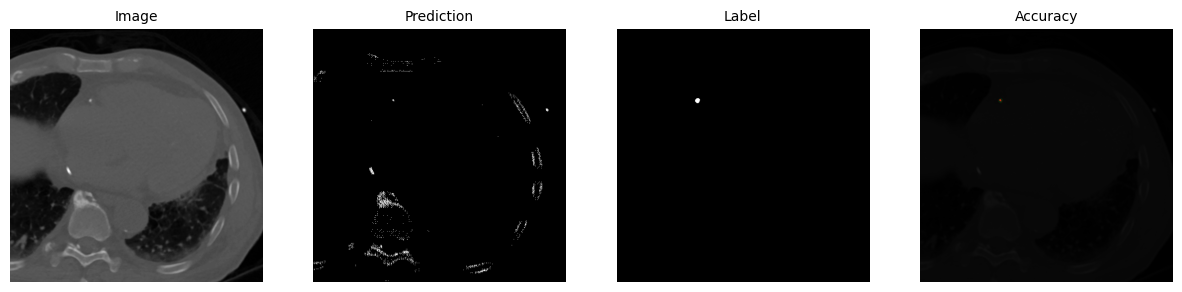

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image Number: 460


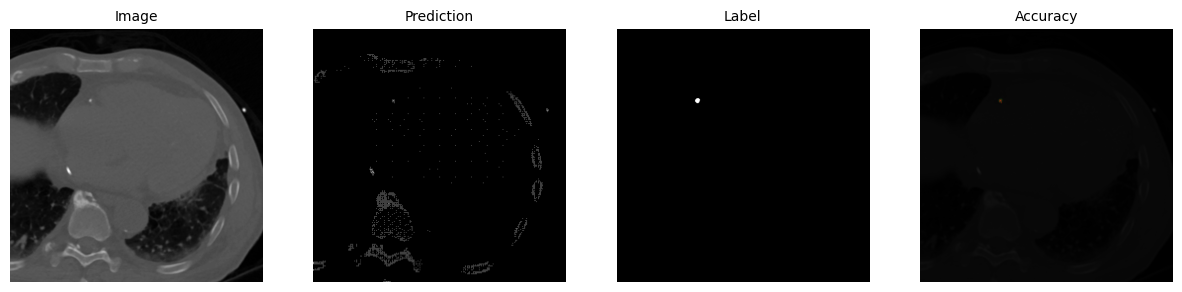

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image Number: 347


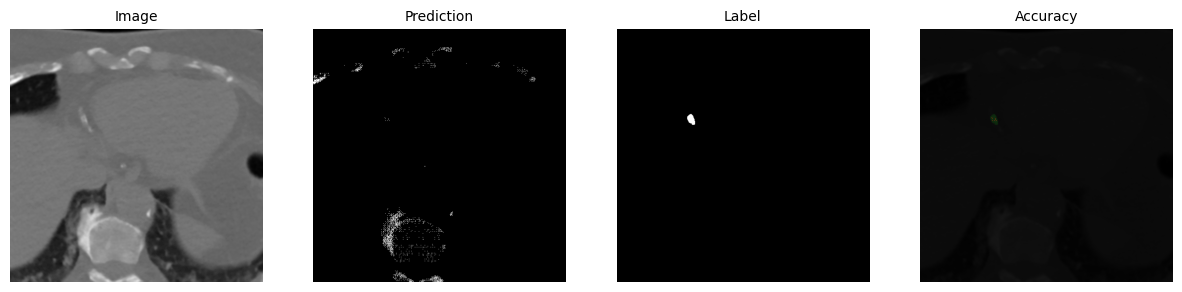

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image Number: 347


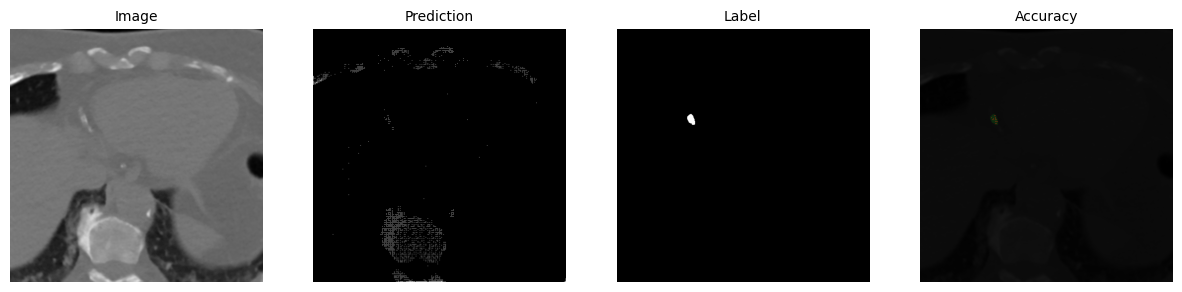

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image Number: 463


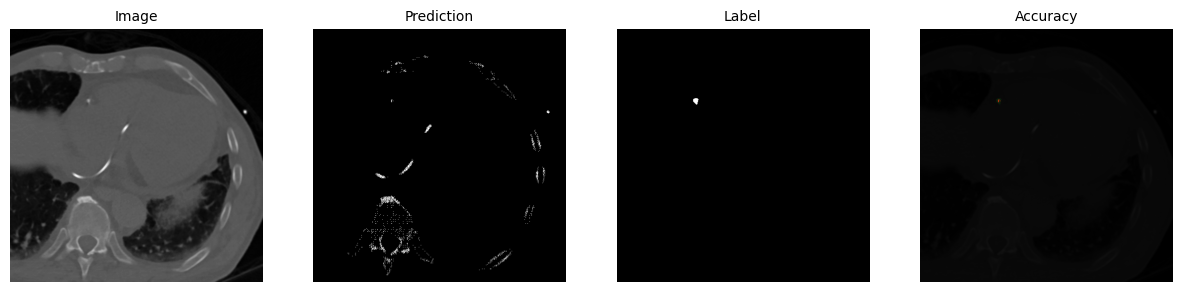

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image Number: 463


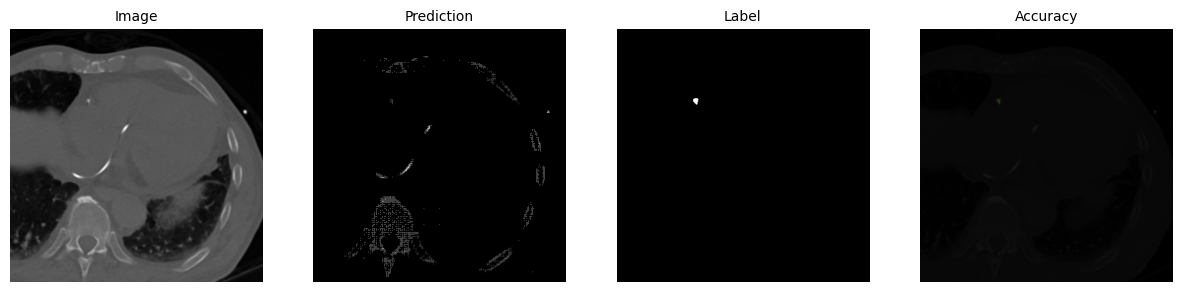

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image Number: 498


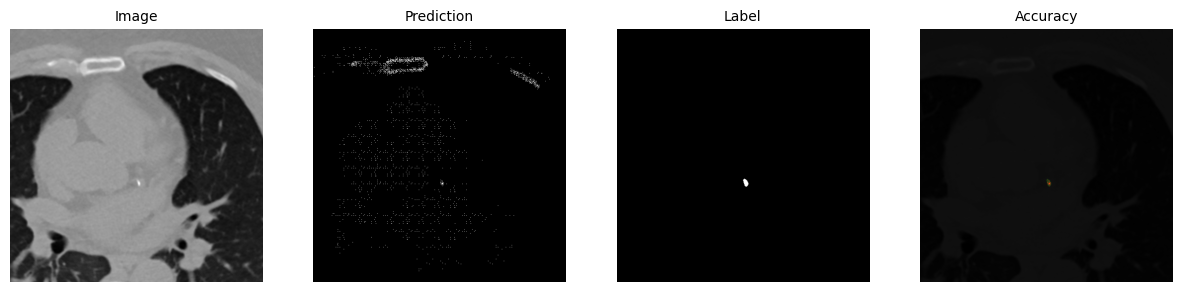

Image Number: 498


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


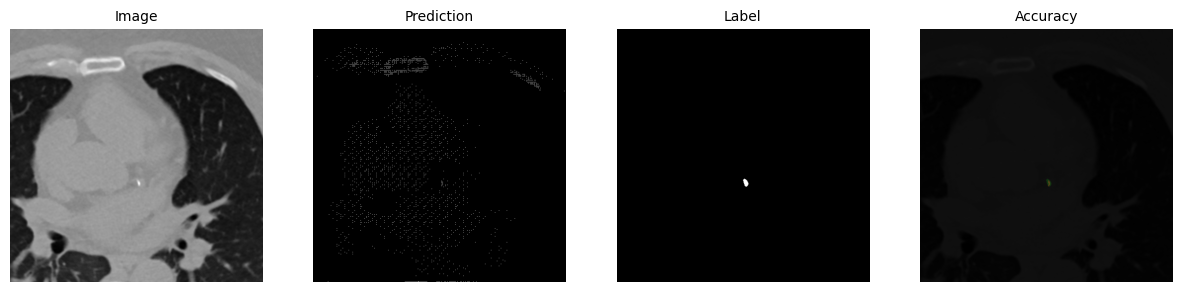

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image Number: 348


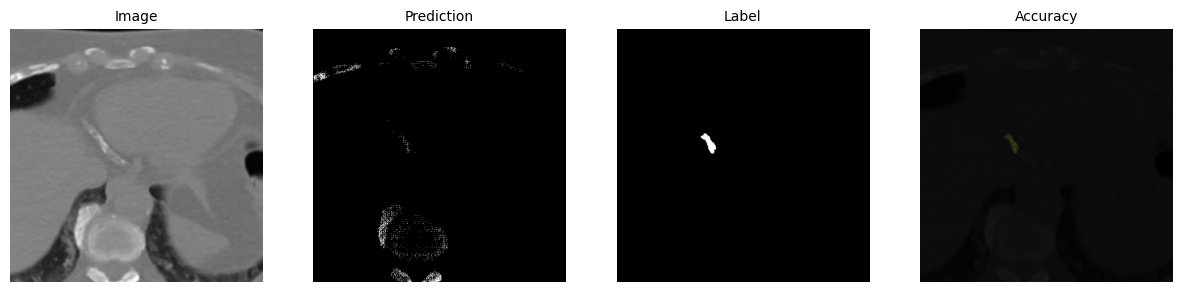

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image Number: 348


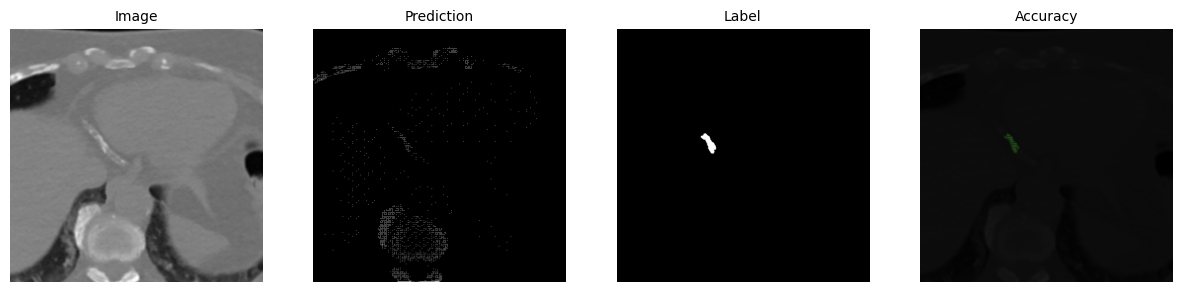

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image Number: 550


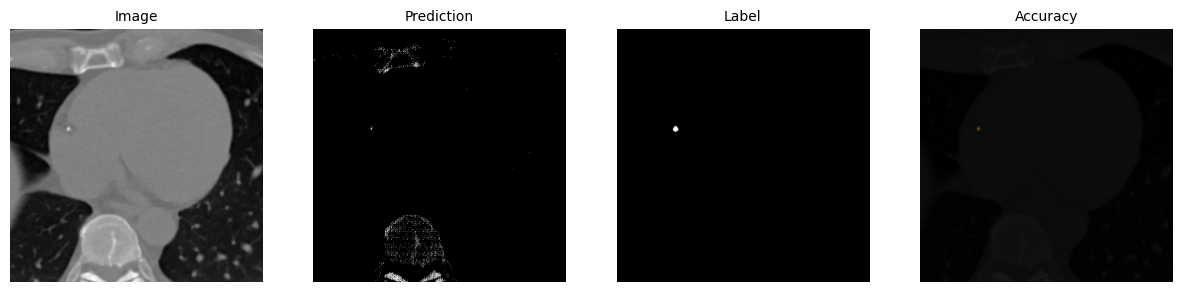

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image Number: 550


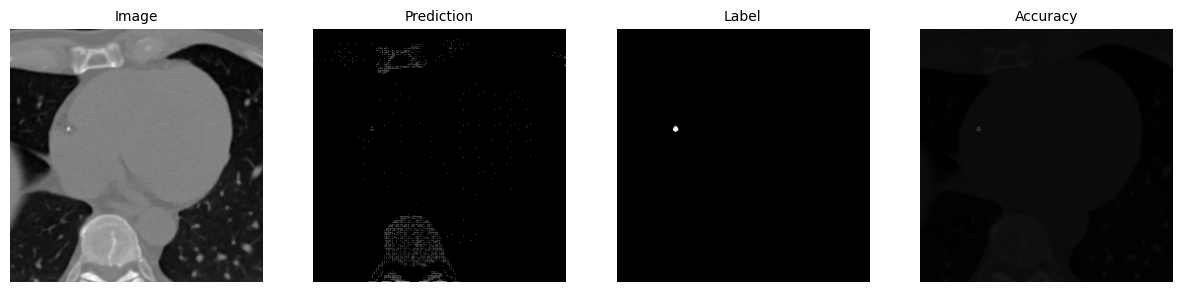

Image Number: 554


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


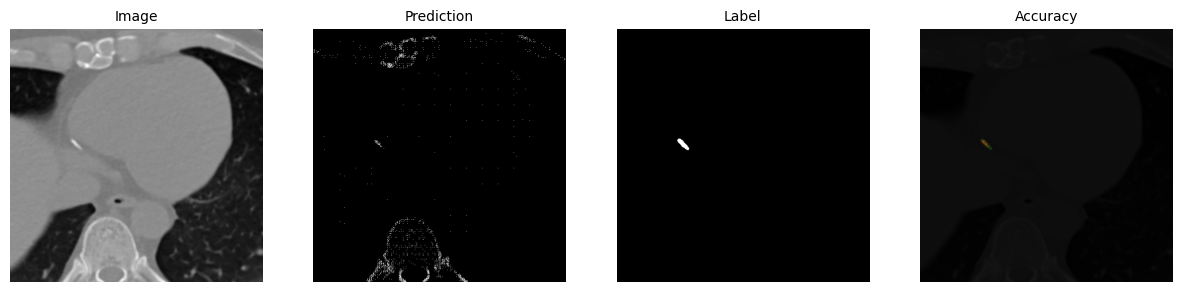

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image Number: 554


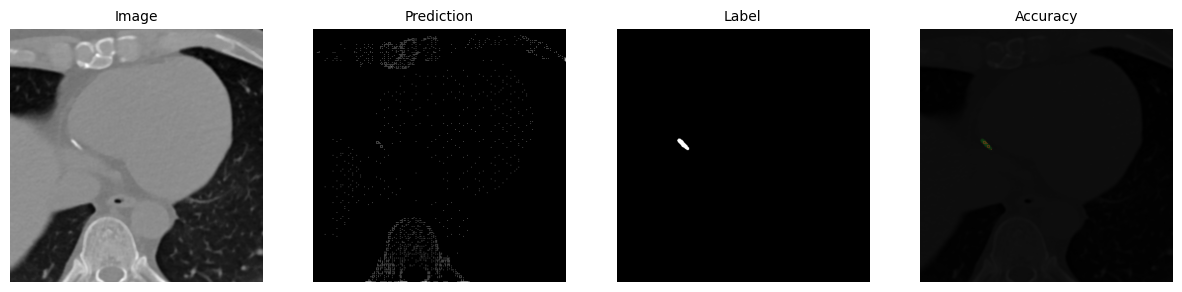

CPU times: total: 4.72 s
Wall time: 19.5 s


In [69]:
%%time
for i in [460, 347, 463, 498, 348, 550, 554]:
    infer_all_models(i, th=99.3)

In [79]:
bce_loss = 0
iou_loss = 0
dice_loss = 0
model = UNET().to(CFG.device)
model.load_state_dict(torch.load(final_models[1]))
with torch.no_grad():
    for x,y in testDL:
        x, y = x.to(CFG.device), y.to(CFG.device)
        pred = model(x)
        pred = pred*x
        loss_bce = criterion_bce(pred, y)
        loss_dice = criterion_dice(pred,y)
        loss_iou = criterion_iou(pred, y)
        bce_loss += loss_bce
        iou_loss += loss_iou
        dice_loss += loss_dice
BCE_LOSS = bce_loss/len(testDL)
DICE_LOSS = dice_loss/len(testDL)
IOU_LOSS = iou_loss/len(testDL)
print(f"BCE: {BCE_LOSS}")
print(f"DICE: {DICE_LOSS}")
print(f"IOU: {IOU_LOSS}")

BCE: 0.7542601227760315
DICE: 0.9996638298034668
IOU: 0.9998137354850769


# Time

In [83]:
inf_images = []
for i in range(100):
    img = test[i][0]
    img = torch.Tensor(img).to(CFG.device).reshape(1,1,512,512)
    inf_images.append(img)


In [84]:
%%time
for i in inf_images:
    model(i)

CPU times: total: 78.1 ms
Wall time: 3.18 s


In [85]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
f"{get_n_params(model)} Trainable Parameters"

'131420267 Trainable Parameters'